# Precipitation based on PERSIANN-CDR

- **In this notebook you will find:**
    - Exploration of a single data file (understanding metadata).
    - Daily data analysis for some years in one grid point (time series, onset and demise dates of `dry` seasons).
    - Make monthly sums for all period of data. Export data files to a specific folder.
- **References:**
    - Arvor, D., Funatsu, B. M., Michot, V., and Dubreuil, V. (2017). Monitoring rainfall patterns in the southern amazon with persiann-cdr data: Long-term characteristics and trends. Remote Sensing, 9(9):889.

## 1 Initial setup

In [1]:
# Load packages.
import sys
import os
import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from datetime import datetime
from dask.diagnostics import ProgressBar
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [2]:
print(">>> Conda environment:")
print("*",  os.environ["CONDA_DEFAULT_ENV"])

print(">>> Versions:")
print("* numpy:", np.__version__)
print("* pandas:", pd.__version__)
print("* xarray:", xr.__version__)

>>> Conda environment:
* deepweather
>>> Versions:
* numpy: 1.18.1
* pandas: 1.0.2
* xarray: 0.15.0


In [3]:
# Format metadata view inside this notebook. 
xr.set_options(display_style="text")

# Clean warning messages.
warnings.filterwarnings("ignore")

In [4]:
# Map borders for South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [5]:
# Main directory.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/PERSIANN_CDR/"

## 2 Single data file exploration

In [6]:
# Single data file exploration.
YEAR = "2010"

# All files inside the folder corresponping to this year.
FILES = sorted(glob.glob(os.path.join(DATA_FOLDER, YEAR) + "/*.nc"))

print(">>>", len(FILES), "data files inside", YEAR, "directory:")

for FILE in FILES[:10]:
    print("*", os.path.basename(FILE))
print("...")    

>>> 365 data files inside 2010 directory:
* PERSIANN-CDR_v01r01_20100101_c20140523.nc
* PERSIANN-CDR_v01r01_20100102_c20140523.nc
* PERSIANN-CDR_v01r01_20100103_c20140523.nc
* PERSIANN-CDR_v01r01_20100104_c20140523.nc
* PERSIANN-CDR_v01r01_20100105_c20140523.nc
* PERSIANN-CDR_v01r01_20100106_c20140523.nc
* PERSIANN-CDR_v01r01_20100107_c20140523.nc
* PERSIANN-CDR_v01r01_20100108_c20140523.nc
* PERSIANN-CDR_v01r01_20100109_c20140523.nc
* PERSIANN-CDR_v01r01_20100110_c20140523.nc
...


In [7]:
# View metadata from a single file.
DATA_FILE = FILES[0]
DS = xr.open_dataset(DATA_FILE)
print("\n>>> Metadata from " + os.path.basename(DATA_FILE) + ":")
print(DS)


>>> Metadata from PERSIANN-CDR_v01r01_20100101_c20140523.nc:
<xarray.Dataset>
Dimensions:        (lat: 480, lon: 1440, nv: 2, time: 1)
Coordinates:
  * time           (time) datetime64[ns] 2010-01-01
  * lat            (lat) float32 59.875 59.625 59.375 ... -59.625 -59.875
  * lon            (lon) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
Dimensions without coordinates: nv
Data variables:
    lon_bnds       (lon, nv) float32 ...
    lat_bnds       (lat, nv) float32 ...
    precipitation  (time, lon, lat) float32 ...
Attributes:
    datetime:                   2010-01-01
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record (CDR) of Precipitati...
    comment:                    Daily PERSIANN-CDR precipitation estimates fo...
    source:                     GRIDSAT-B1.2010.01.01.00.v02r01.nc,GRIDSAT-B1...
    Metadata_Conventions:       CF-1.6,Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:   CF Standard Nam

## 3 Compound single daily time series for some years

In [8]:
%%time

# Time range.
FILES = []
years = range(1998, 2001 + 1)
for year in years:
    
    # Each data directory contains one year of data.
    YEAR = str(year)

    # All files inside the folder corresponping to this year.
    FILES = FILES + sorted(glob.glob(os.path.join(DATA_FOLDER, YEAR) + "/*.nc"))

# Lazily load all data.
DS = xr.open_mfdataset(
    paths=FILES,
    concat_dim="time",
    drop_variables=["lon_bnds", "lat_bnds"],
    mask_and_scale=True
)

# Shift longitudes and guarantee ordering of coordinates.
DS = DS.assign_coords(lon=(DS.lon + 180) % 360 - 180)
DS = DS.sortby(DS.lat)
DS = DS.sortby(DS.lon)
DS = DS.sortby(DS.time)
DS = DS.transpose("time", "lat", "lon")

# South America.
DS = DS.sel(lat=slice(lati, latf), lon=slice(loni, lonf))

DS

CPU times: user 17.7 s, sys: 513 ms, total: 18.2 s
Wall time: 24.8 s


<xarray.Dataset>
Dimensions:        (lat: 320, lon: 240, time: 1461)
Coordinates:
  * lon            (lon) float32 -89.875 -89.625 -89.375 ... -30.375 -30.125
  * lat            (lat) float32 -59.875 -59.625 -59.375 ... 19.625 19.875
  * time           (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2001-12-31
Data variables:
    precipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 320, 240), meta=np.ndarray>
Attributes:
    datetime:                   1998-01-01
    Conventions:                CF-1.6
    title:                      NOAA Climate Data Record (CDR) of Precipitati...
    comment:                    Daily PERSIANN-CDR precipitation estimates fo...
    source:                     GRIDSAT-B1.1998.01.01.00.v02r01.nc,GRIDSAT-B1...
    Metadata_Conventions:       CF-1.6,Unidata Dataset Discovery v1.0, NOAA C...
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    id:                         PERSIANN-CDR_v01r01_19980101_c20140523.nc
    naming_authority:           gov.noaa.ncdc
    date_created:               2014-05-23T02:51:15Z
    license:                    No constraints on data access or use.
    summary:                    Daily near global precipitation estimates at ...
    keywords:                   EARTH SCIENCE > ATMOSPHERE > PRECIPITATION
    keywords_vocabulary:        GCMD Keywords, Version 8.0.0.0.0
    cdm_data_type:              Grid
    project:                    Satellite Data Support for Hydrologic and Wat...
    creator_name:               Dan Braithwaite
    creator_email:              dbraithw@uci.edu
    creator_url:                http://www.chrs.web.uci.edu/
    institution:                UC-IRVINE/CHRS, Center for Hydrometeorology a...
    geospatial_lat_min:         -60.0
    geospatial_lat_max:         60.0
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    time_coverage_start:        1998-01-01T00:00Z
    time_coverage_end:          1998-01-01T23:59Z
    contributor_name:           Soroosh Sorooshian, Kuolin Hsu, Hamed Ashouri...
    contributor_role:           PrincipalInvestigator, Professor, Author, Author
    cdr_program:                NOAA Climate Data Record Program
    cdr_variable:               precipitation
    metadata_link:              gov.noaa.ncdc:C00854
    product_version:            v01r01
    spatial_resolution:         0.25 degrees

In [9]:
# Time series for some location in South America.
TS = DS.precipitation.sel(lat=-6, lon=-60, method="nearest")

In [10]:
# Load data into memory.
with ProgressBar():
    TS = TS.load()

[########################################] | 100% Completed | 53.1s


In [11]:
%%time

# Calculate anomalous accumlulation (similar to equation 7 of Arvor et al. 2017).
AA = (TS - TS.mean()).cumsum()

CPU times: user 1.2 ms, sys: 116 µs, total: 1.31 ms
Wall time: 1.12 ms


CPU times: user 90.7 ms, sys: 3.86 ms, total: 94.6 ms
Wall time: 114 ms


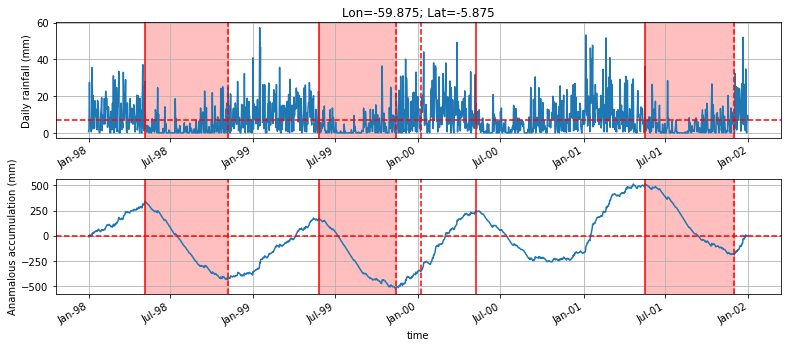

In [12]:
%%time

# Just for aesthetic porposes.
months = mdates.MonthLocator([1, 7])
months_fmt = mdates.DateFormatter("%b-%y")

# Make figure and axes.
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))

# Plot time series for this location.
TS.plot(ax=ax[0])
ax[0].axhline(y=TS.mean("time").values, ls="--", color="red", label="Average")
ax[0].set_ylabel("Daily rainfall (mm)")
ax[0].set_xlabel("")
ax[0].set_title(f"Lon={TS.lon.values}; Lat={TS.lat.values}")
ax[0].xaxis.set_major_locator(months)
ax[0].xaxis.set_major_formatter(months_fmt)

# Plot anomalous accumulation.
plt.subplots_adjust(hspace=0.35)
AA.plot(ax=ax[1])
ax[1].axhline(y=0, ls="--", color="red", label="Zero")
ax[1].set_title("")
ax[1].set_ylabel("Anamalous accumulation (mm)")
ax[1].xaxis.set_major_locator(months)
ax[1].xaxis.set_major_formatter(months_fmt)

# Find onset, demise, and duration of DRY season for each year.
for year in years:

    # Time series for this year.    
    AAy = AA[AA.time.dt.year==year]
    
    # Please note that this is opposity in regarding RAINY season in Arvor et al. 2017.
    onset = AAy.time[AAy.argmax(dim="time")].values
    demise = AAy.time[AAy.argmin(dim="time")].values

    # For first plot.
    ax[0].axvline(x=onset, ls="-", color="red")
    ax[0].axvline(x=demise, ls="--", color="red")
        
    # For second one.
    ax[1].axvline(x=onset, ls="-", color="red")
    ax[1].axvline(x=demise, ls="--", color="red")        
    
    # Sanity checks 
    if (onset < demise) and (pd.to_datetime(onset).year==pd.to_datetime(demise).year):
                
        # Plot dry season duration.
        ax[0].axvspan(xmin=onset, xmax=demise, color="red", alpha=0.25)
        ax[1].axvspan(xmin=onset, xmax=demise, color="red", alpha=0.25)
    
# Further adjustments.
ax[0].grid()
ax[1].grid()

## 4 `Global` cumulative values, export results, and visualize 

In [13]:
# Each folder is a year in the original data files.
DATA_FOLDER_YEARS = [
    DATA_FOLDER + dirname for dirname in sorted(os.listdir(path=DATA_FOLDER)) \
    if not dirname.isalpha() 
]

# Where to put preprocessed data.
DATA_FOLDER_OUTPUT = "/media/alex/ALEXDATA/data_sets/PERSIANN_CDR/msum/"
if not os.path.isdir(DATA_FOLDER_OUTPUT):
    os.mkdir(DATA_FOLDER_OUTPUT)

In [14]:
%%time

# Loop over years.
for DATA_FOLDER_YEAR in DATA_FOLDER_YEARS:
    
    YEAR = os.path.basename(DATA_FOLDER_YEAR)
    print(">>> Processing " + YEAR + " ...", end=" ")
    
    # All files inside this folder.
    FILES = []
    FILES = FILES + sorted(glob.glob(DATA_FOLDER_YEAR + "/*.nc"))    
    
    # Lazily load all data.
    DS = xr.open_mfdataset(
        paths=FILES,
        concat_dim="time",
        drop_variables=["lon_bnds", "lat_bnds"],
        mask_and_scale=True
    )

    # Shift longitudes and guarantee ordering of coordinates.
    DS = DS.assign_coords(lon=(DS.lon + 180) % 360 - 180)
    DS = DS.sortby(DS.lat)
    DS = DS.sortby(DS.lon)
    DS = DS.sortby(DS.time)
    DS = DS.transpose("time", "lat", "lon")

    # Monthly cumulative value    
    DS = DS.resample(indexer={"time": "1MS"}, keep_attrs=True).sum("time", keep_attrs=True)
    
    # My attributes.
    now = datetime.now()
    now_str = now.strftime("%B %d, %Y; %Hh:%Mmin:%Ss")
    DS.attrs["build"] = "Monthly cumulative values by Alex Araujo"
    DS.attrs["build_date"] = now_str
    
    # Load into memory.
    DS = DS.load()

    # Export results as a netcdf file.
    DS.to_netcdf(path=DATA_FOLDER_OUTPUT + "msum_precipitation_" + YEAR + ".nc" , mode="w")
    
    print("Done! (sanity ckeck:", str(np.unique(DS.time.dt.year.values)[0]) + ")")

>>> Processing 1983 ... Done! (sanity ckeck: 1983)
>>> Processing 1984 ... Done! (sanity ckeck: 1984)
>>> Processing 1985 ... Done! (sanity ckeck: 1985)
>>> Processing 1986 ... Done! (sanity ckeck: 1986)
>>> Processing 1987 ... Done! (sanity ckeck: 1987)
>>> Processing 1988 ... Done! (sanity ckeck: 1988)
>>> Processing 1989 ... Done! (sanity ckeck: 1989)
>>> Processing 1990 ... Done! (sanity ckeck: 1990)
>>> Processing 1991 ... Done! (sanity ckeck: 1991)
>>> Processing 1992 ... Done! (sanity ckeck: 1992)
>>> Processing 1993 ... Done! (sanity ckeck: 1993)
>>> Processing 1994 ... Done! (sanity ckeck: 1994)
>>> Processing 1995 ... Done! (sanity ckeck: 1995)
>>> Processing 1996 ... Done! (sanity ckeck: 1996)
>>> Processing 1997 ... Done! (sanity ckeck: 1997)
>>> Processing 1998 ... Done! (sanity ckeck: 1998)
>>> Processing 1999 ... Done! (sanity ckeck: 1999)
>>> Processing 2000 ... Done! (sanity ckeck: 2000)
>>> Processing 2001 ... Done! (sanity ckeck: 2001)
>>> Processing 2002 ... Done! (

In [15]:
# Read all these cumulative monthly data.
FILES = sorted(glob.glob(DATA_FOLDER_OUTPUT + "/*.nc"))

# 2020 did not pass the sanity check.
FILES = FILES[:-1]

In [16]:
# Load data into memory.
DS = xr.open_mfdataset(paths=FILES)

with ProgressBar():
    DS = DS.load()

[########################################] | 100% Completed | 18.3s


In [17]:
%%time

# Monthly mean.
DS = DS.groupby("time.month").mean("time")

CPU times: user 1.01 s, sys: 490 ms, total: 1.5 s
Wall time: 1.58 s


>>> MIN: 0.0
>>> MAX: 907.99713
>>> MEAN: 83.463806
>>> MEDIAN: 72.240555



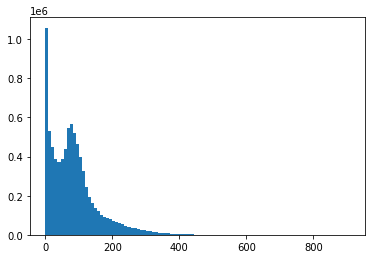

In [18]:
print(">>> MIN:", np.nanmin(DS.precipitation.values.flatten()))
print(">>> MAX:", np.nanmax(DS.precipitation.values.flatten()))
print(">>> MEAN:", np.nanmean(DS.precipitation.values.flatten()))
print(">>> MEDIAN:", np.nanmedian(DS.precipitation.values.flatten()))
print()
plt.hist(DS.precipitation.values.flatten(), bins=100);

CPU times: user 3.12 s, sys: 64.5 ms, total: 3.18 s
Wall time: 3.36 s


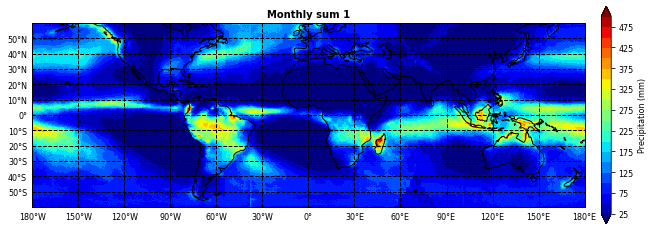

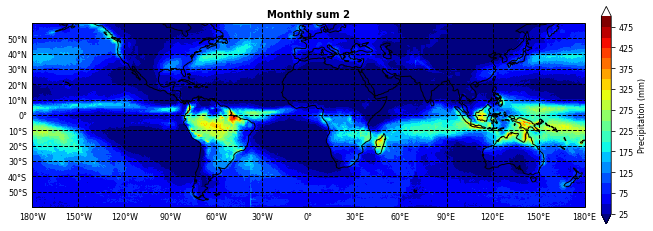

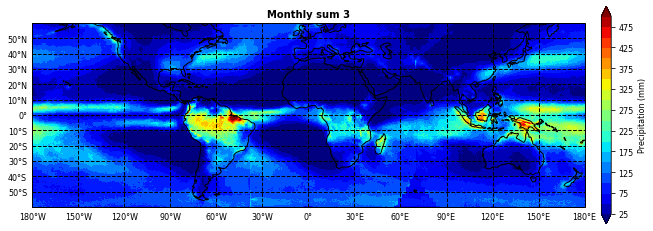

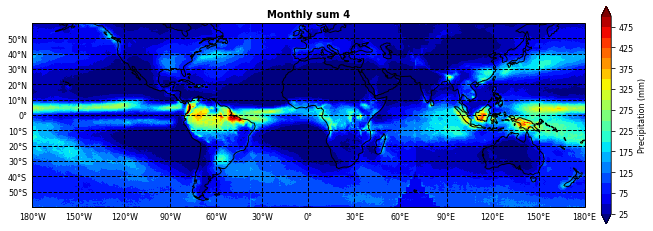

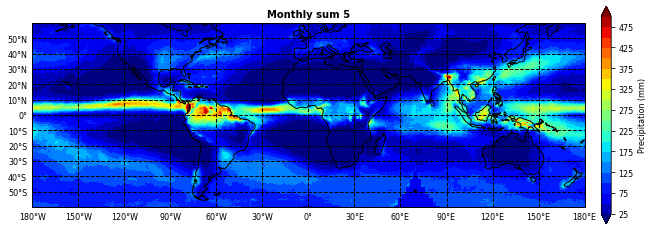

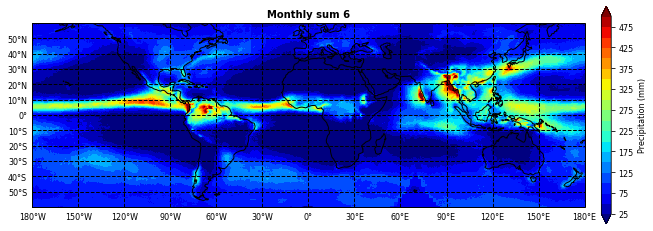

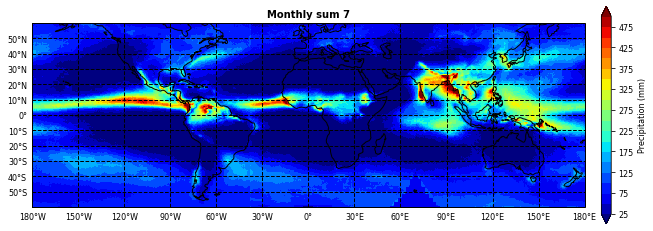

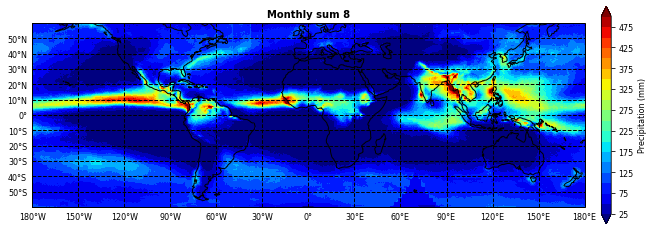

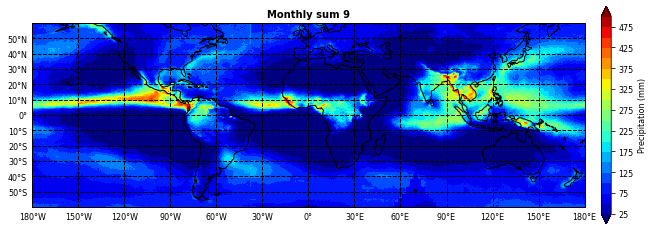

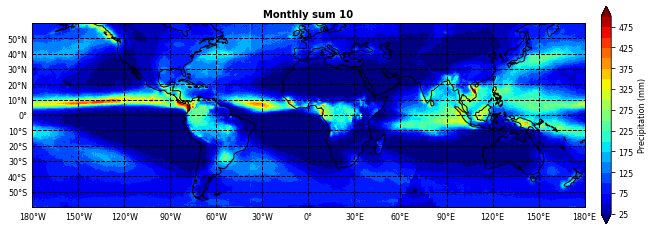

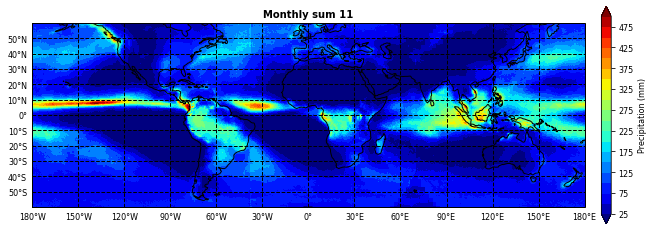

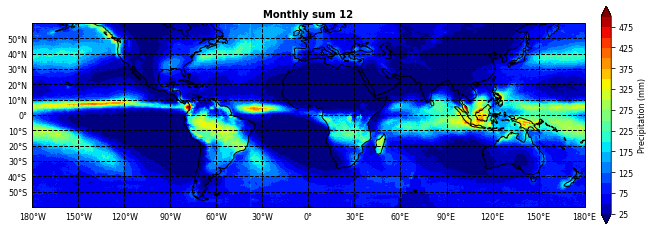

In [19]:
%%time

# One map for each month
for MONTH in DS.month:
    
    # Set figure size, projection, and extent.
    fig = plt.figure(figsize=(12, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -60, 60]) 

    # Add coastlines and formatted gridlines.
    ax.coastlines(resolution="110m", linewidth=1)
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), 
        draw_labels=True, 
        linewidth=1, 
        color="black", 
        linestyle="--"
    )
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180 + 30, 30))
    gl.ylocator = mticker.FixedLocator(np.arange(-60, 60 + 10, 10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {"size": 8, "color": "black"}
    gl.ylabel_style = {"size": 8, "color": "black"}
    
    # Draw the plot.
    p = DS.precipitation.sel(month=MONTH).plot(
        ax=ax,
        vmin=25,
        vmax=500,
        levels=np.arange(25, 500 + 25, 25),
        cmap=plt.cm.jet,
        add_colorbar=False,
        add_labels=False
    )
    
    # Adjustments.
    plt.title(f"Monthly sum {MONTH.values}", weight="bold", size=10)
    cb = plt.colorbar(
        mappable=p, 
        ax=ax, 
        orientation="vertical", 
        pad=0.025, 
        shrink=0.8,
        extend="both"
    )
    cb.set_label("Precipitation (mm)", size=8)
    cb.ax.tick_params(labelsize=8)       